In [2]:
# !pip3 install ax-platform

In [16]:
# Imports
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from ax.service.ax_client import AxClient


# Defining a custom wrapper class for our Protein Structures

In [17]:
# Defining a Protein structure class
class ProteinDataset(Dataset):
    def __init__(self, seqs_df, pssm_dir, labels_df = None, data_type='train'):
        self.seqs_df = seqs_df
        self.pssm_dir = pssm_dir
        self.labels_df = labels_df
        self.data_type = data_type
    
    def __len__(self):
        return len(self.seqs_df)
    
    def __getitem__(self, idx):
        # Fetching the pdb_id from seqs_df 
        pdb_id = self.seqs_df.iloc[idx]['PDB_ID']
        # Fetching the pssm data from the folder using the pdb_id and file path
        pssm_file = os.path.join(self.pssm_dir,f"{self.data_type}/" ,f"{pdb_id}_{self.data_type}.csv")
        pssm_df = pd.read_csv(pssm_file)
        pssm_data = pssm_df.iloc[:, 2:].astype(float).to_numpy()

        # Fetching and converting the labels if the data_type is train
        # We skip this in case data type is test, as there are no labels
        if self.data_type == 'train':
            label = self.labels_df[self.labels_df['PDB_ID'] == pdb_id]['SEC_STRUCT'].values[0]
            label_array = [self.label_to_array(l) for l in label]
            label_data = np.array(label_array)
            return pssm_data, label_data
        else:
            return pssm_data
    
    # Function to convert the Labels to a vector
    def label_to_array(self, label):
        if label == 'C':
            return [1, 0, 0]
        elif label == 'E':
            return [0, 1, 0]
        elif label == 'H':
            return [0, 0, 1]


# Loading the data

In [18]:
# Defining the train and test df by raeding the csv files
seqs_train = pd.read_csv("/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv")
labels_train = pd.read_csv("/kaggle/input/deep-learning-for-msc-202324/labels_train.csv")
seqs_test = pd.read_csv("/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv")
pssm_dir = '/kaggle/input/deep-learning-for-msc-202324/'

# Splitting the training data into training and validation data
# using an 80% - 20% split
train_seqs, val_seqs, train_labels, val_labels = train_test_split(seqs_train, labels_train, test_size=0.2, random_state=42)


# Creating dataset and dataloader for train, val and test splits
train_dataset = ProteinDataset(train_seqs, pssm_dir, train_labels, data_type = "train")
val_dataset = ProteinDataset(val_seqs, pssm_dir, val_labels, data_type = "train")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = ProteinDataset(seqs_test, pssm_dir, data_type = 'test')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Defining the Fully Convolutional PyTorch model

In [19]:
# Defining the FCNN Model using PyTorch
class ConvolutionalModel(nn.Module):
    def __init__(self, dropout_rate = 0.5):
        super(ConvolutionalModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=20, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=5, padding=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv4 = nn.Conv1d(in_channels=512, out_channels=3, kernel_size=5, padding=2)
        
    # Method to carry out a forward pass
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.conv4(x)
        return x


# Training the Model and checking accuracy on Validation set

Training... epoch:  1
Testing on val... epoch:  1
Epoch 1/5, Train Loss: 0.5999140680187961, Val Loss: 0.5315008249211979
Train Accuracy: 0.7502405218738023, Val Accuracy: 0.7763622078300147
Training... epoch:  2
Testing on val... epoch:  2
Epoch 2/5, Train Loss: 0.5335904952986947, Val Loss: 0.5188378894766728
Train Accuracy: 0.778410130859543, Val Accuracy: 0.7822502136397642
Training... epoch:  3
Testing on val... epoch:  3
Epoch 3/5, Train Loss: 0.510502933316426, Val Loss: 0.5174799625898575
Train Accuracy: 0.7850626139056841, Val Accuracy: 0.7833958862215655
Training... epoch:  4
Testing on val... epoch:  4
Epoch 4/5, Train Loss: 0.49594907129030363, Val Loss: 0.5208212529002995
Train Accuracy: 0.7888460425352178, Val Accuracy: 0.7823441212284364
Training... epoch:  5
Testing on val... epoch:  5
Epoch 5/5, Train Loss: 0.47963295482820345, Val Loss: 0.5072657613800122
Train Accuracy: 0.792606005616088, Val Accuracy: 0.7888268750997768


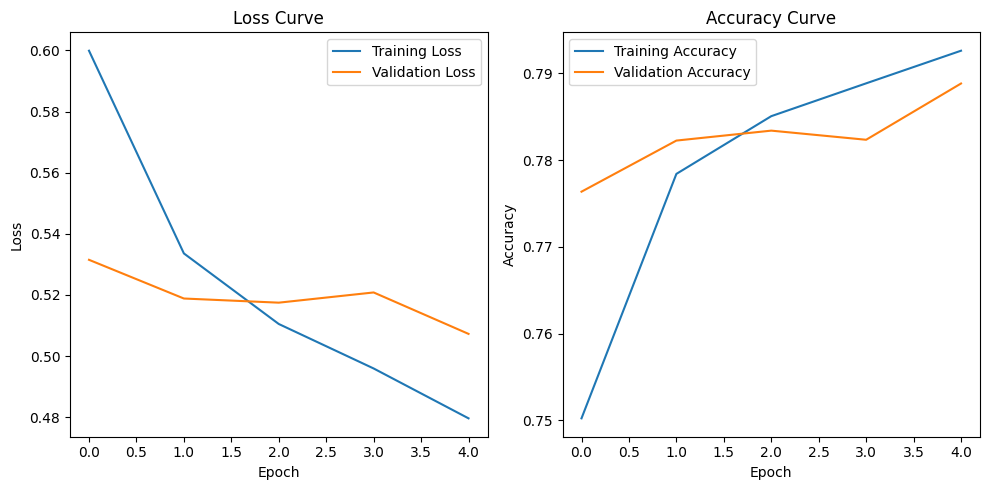

0.7888268750997768

In [20]:
# This is the training loop for the model
def train_val_loop(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        # Training step
        model.train()
        train_loss = 0.0
        correct_pred_train = 0
        total_pred_train = 0
        print("Training... epoch: ", epoch+1)
        for inputs, labels in train_loader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.float().transpose(1, 2)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.transpose(1, 2).reshape(-1, 3)
            labels = labels.argmax(dim=2).reshape(-1)
            
            
            i, pred = torch.max(outputs, 1)
            correct_pred_train +=  (pred == labels).sum().item()
            total_pred_train += labels.size(0)
            
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_accuracy = correct_pred_train/total_pred_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        correct_pred_val = 0
        total_pred_val = 0
        with torch.no_grad():
            print("Testing on val... epoch: ", epoch+1)
            for inputs, labels in val_loader:

                inputs = inputs.to(device)
                labels = labels.to(device)
                inputs = inputs.float().transpose(1, 2)
                
                outputs = model(inputs)
                outputs = outputs.transpose(1, 2).reshape(-1, 3)
                labels = labels.argmax(dim=2).reshape(-1)
                
                i, pred = torch.max(outputs, 1)
                correct_pred_val +=  (pred == labels).sum().item()
                total_pred_val += labels.size(0)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
            val_accuracy = correct_pred_val/total_pred_val
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(val_loader)}')
        print(f'Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return val_accuracy
# Initialize model and hyperparameters
model = ConvolutionalModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
train_val_loop(model, train_loader, val_loader, criterion, optimizer, epochs, device)


# Using Ax to optimze hyperparameters

[INFO 03-18 15:02:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter dropout_rate. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 15:02:27] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter learning_rate. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-18 15:02:27] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='dropout_rate', parameter_type=FLOAT, range=[0.1, 0.5]), RangeParameter(name='learning_rate', parameter_type=FLOAT, range=[1e-06, 0.001], log_scale=True)], parameter_constraints=[]).
[INFO 03-18 15:02:27] ax.modelbridge.dispatch_utils: Using Models.BOTORCH_MODULAR since there is at least one ordered parameter and there are no unordered categorical parameters.
[

Training... epoch:  1
Testing on val... epoch:  1
Epoch 1/2, Train Loss: 0.9805566930583307, Val Loss: 0.8592925881172394
Train Accuracy: 0.5114637027071421, Val Accuracy: 0.6118548939939836
Training... epoch:  2
Testing on val... epoch:  2
Epoch 2/2, Train Loss: 0.8024087647803232, Val Loss: 0.7565844202270875
Train Accuracy: 0.6511126580991341, Val Accuracy: 0.6804356060013209


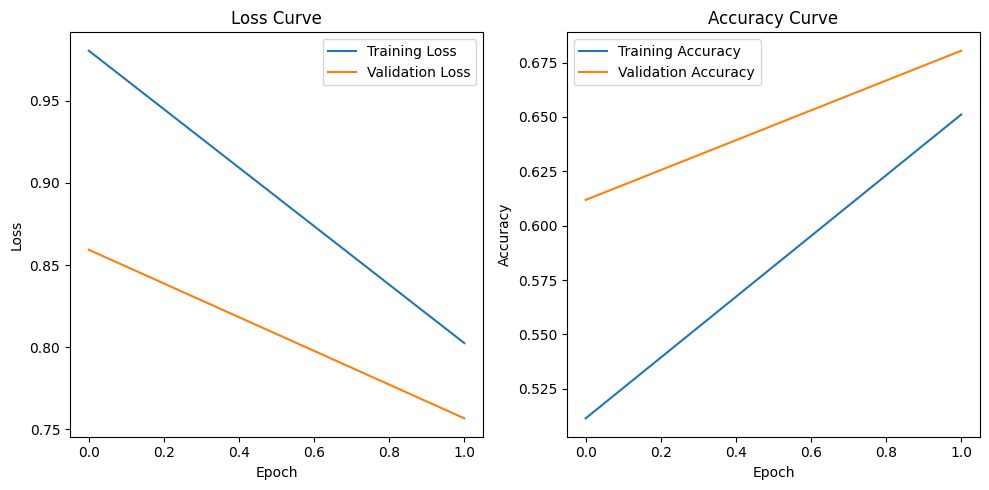

[INFO 03-18 15:04:35] ax.service.managed_loop: Running optimization trial 2...


Training... epoch:  1
Testing on val... epoch:  1
Epoch 1/2, Train Loss: 0.6499420475755278, Val Loss: 0.5696418584122525
Train Accuracy: 0.7271605903932044, Val Accuracy: 0.7608111111458917
Training... epoch:  2
Testing on val... epoch:  2
Epoch 2/2, Train Loss: 0.5591302796087873, Val Loss: 0.5665136860071363
Train Accuracy: 0.7676707314211518, Val Accuracy: 0.764257519650163


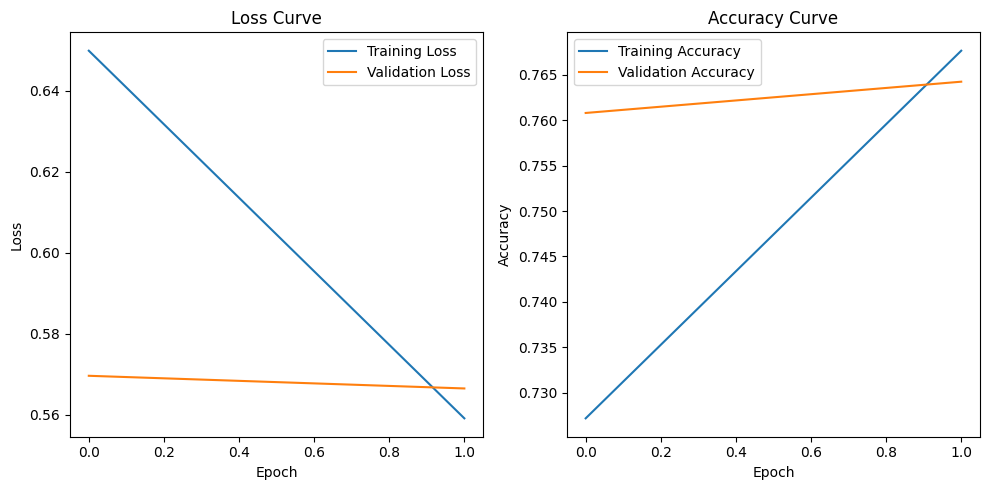

Best parameters: {'dropout_rate': 0.1653231978416443, 'learning_rate': 0.00015047281284735146}
Best validation accuracy: ({'val_accuracy': 0.764257519650163}, {'val_accuracy': {'val_accuracy': 0.0}})


In [8]:
from ax.service.managed_loop import optimize
# Using Ax for optimization, however limiting the scope and extent for this assignment.
def train_evaluate(parameterization):
    dropout_rate = parameterization.get("dropout_rate", 0.5)
    learning_rate = parameterization.get("learning_rate", 0.001)
    
    model = ConvolutionalModel(dropout_rate=dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    val_accuracy = train_val_loop(model, train_loader, val_loader, criterion, optimizer, epochs=2, device='cuda')
    
    
    return {"val_accuracy": val_accuracy}  


best_parameters, best_values, experiment, model = optimize(
    parameters=[
        {"name": "dropout_rate", "type": "range", "bounds": [0.1, 0.5]},
        {"name": "learning_rate", "type": "range", "bounds": [1e-6, 1e-3], "log_scale": True},
    ],
    evaluation_function=train_evaluate,
    objective_name='val_accuracy',
    total_trials=2
)

print(f"Best parameters: {best_parameters}")
print(f"Best validation accuracy: {best_values}")


# Predicting structures of Test set

In [22]:
model.eval()
output = []
val_to_HEC = {0:'C', 1:'E', 2:'H'}
# Predicting the secondary structures of the test dataset
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        inputs = inputs.float().transpose(1, 2)
        outputs = model(inputs)
        outputs = outputs.transpose(1, 2).reshape(-1, 3)
        i, predicted = torch.max(outputs, 1)
        output += [val_to_HEC[x.item()] for x in predicted]
        
# Creating a list of pdb-ids with the index numbers for the length of the predicted 
# sequence for that id       
ids = []
for index, data in seqs_test.iterrows():
    pdb_id = data['PDB_ID']
    sequence = data['SEQUENCE']
    for i, seqs_char in enumerate(sequence, start=1):
        ids.append(pdb_id+'_'+str(i))
        
# creating a list of the predictions paried with the pdb-id
output_df = pd.DataFrame({'ID': ids, 'STRUCTURE': output})
# storing the predictions in a submission.csv file      
output_df.to_csv("submission.csv", index=False)